# Project Inquiries:

1) Is the Earth’s temperature rising over time?

2) Does Earth’s temperature fluctuate in a predictable pattern?

3) Can we use readings of past Earth temperatures to predict future Earth temperatures?

4) Does taking the average temperature over land very in pattern, predictability, or variability from temperature taken over land and ocean?

In [1]:
# imports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from math import sqrt
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

import fbprophet

import wrangle
import explore
import modeling

import warnings
warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.


# Acquire

In [2]:
df = pd.read_csv('GlobalTemperatures.csv')
df.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


# Prepare

•	set data to date time <br>
•	sorted rows by date <br>
•	set date as index <br>
•	created separate dataframes for average land temperature and average land and ocean temperature <br>
•	converted temperature form both dataframes to farenhight <br>
•	removed data prior to ‘1753’ from the land only dataframe to remove nulls <br>
•	removed data prior to '1850' from the land and ocean dataframe to remove nulls <br>

In [3]:
df_land, df_ocean = wrangle.pre_split_prep(df)

### Split Data
•	~80% train <br>
•	~13% validate <br>
•	~7% test <br>
•	data seperated at the end of the nearest year

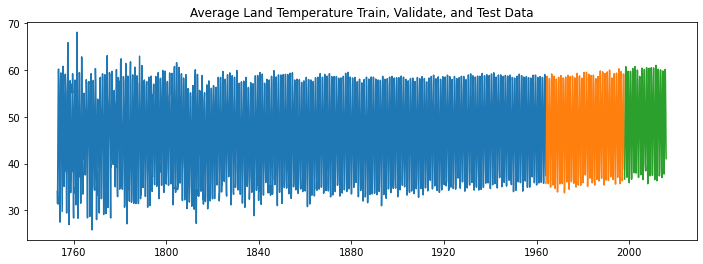

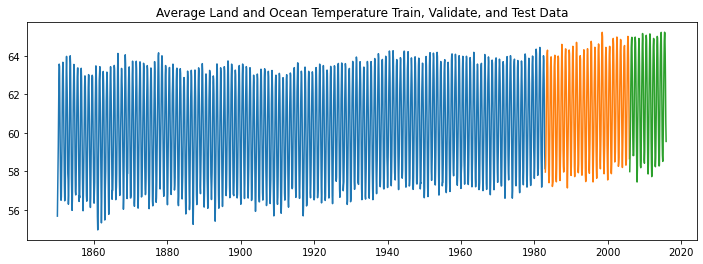

In [4]:
train_land, validate_land, test_land, train_ocean, validate_ocean, test_ocean = wrangle.tvt_split(df_land, df_ocean)

In [5]:
train_ocean

,LandAndOceanAverageTemperature
dt,
1850-01-01,55.666
1850-02-01,57.176
1850-03-01,58.086
1850-04-01,59.334
1850-05-01,61.014
...,...
1982-08-01,63.734
1982-09-01,62.708
1982-10-01,60.986


In [6]:
validate_ocean

,LandAndOceanAverageTemperature
dt,
1983-01-01,57.958
1983-02-01,58.338
1983-03-01,59.366
1983-04-01,60.936
1983-05-01,62.680
...,...
2005-08-01,64.750
2005-09-01,63.806
2005-10-01,62.050


In [7]:
test_ocean

,LandAndOceanAverageTemperature
dt,
2006-01-01,57.980
2006-02-01,58.870
2006-03-01,59.932
2006-04-01,61.458
2006-05-01,62.926
...,...
2015-08-01,65.178
2015-09-01,64.098
2015-10-01,62.580


# Explore

In [8]:
train_land.describe()

,LandAverageTemperature
count,2532.000000
mean,46.421765
std,8.835657
min,25.840000
25%,38.159000
50%,46.860000
75%,54.684500
max,68.042000


### Land

•	Mean: 46 <br>
•	Std: 9 <br>
•	Range: 26 - 68 = 42 <br>

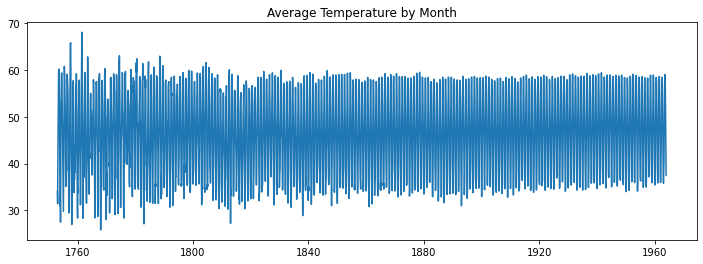

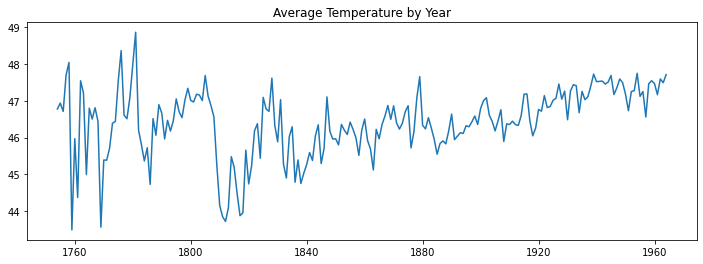

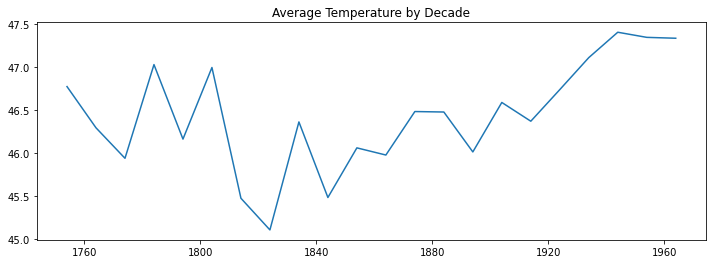

In [9]:
explore.plot_land_exploration(train_land)

### Land

•	Monthly average temperature chart shows a large variability in temperature towards the beginning of the data which decreases over time (Possibly the result of innovations in temperature reading technology).
•	Yearly average temperature chart shows a clear warming trend beginning in the early 1800’s and continuing to the end of the training data. Over this time the yearly average temperature for the Earth has risen about 3 degrees

In [ ]:
train_ocean.describe()

In [ ]:
explore.show_explore(train_land, validate_land, test_land, train_ocean, validate_ocean, test_ocean)

In [ ]:
explore.show_sesonal_decomp(train_land, validate_land, test_land, train_ocean, validate_ocean, test_ocean)

# Modeling

### Make predictions using last observed value

In [ ]:
eval_df_land = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df_ocean = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

In [ ]:
eval_df_land = modeling.last_observed_value(train_land, validate_land, 'LandAverageTemperature', eval_df_land)
eval_df_land = modeling.simple_average(train_land, validate_land, 'LandAverageTemperature', eval_df_land)
eval_df_land = modeling.moving_average(train_land, validate_land, 'LandAverageTemperature', eval_df_land)

Moving one year is the best implies that there has been a shift in temperature over time

### Make predictions using Holt's Linear Trend

In [ ]:
eval_df_land = modeling.holt(train_land, validate_land, 'LandAverageTemperature', eval_df_land)

### Make Predictions using previous cycle

In [ ]:
eval_df_land = modeling.next_cycle(df_land[:'1996'], df_land['1996'], df_land['1997'], 'LandAverageTemperature', eval_df_land)

In [ ]:
eval_df_ocean = modeling.next_cycle(df_ocean[:'2003'], df_ocean['2003'], df_ocean['2004'], 'LandAndOceanAverageTemperature', eval_df_ocean)

### Make predictions using the Holt-Winter method

In [ ]:
eval_df_land = modeling.holt_winter(train_land, validate_land, 'LandAverageTemperature', eval_df_land)

In [ ]:
eval_df_ocean = modeling.holt_winter(train_ocean, validate_ocean, 'LandAndOceanAverageTemperature', eval_df_ocean)

In [ ]:
eval_df_land

In [ ]:
eval_df_ocean

In [ ]:
train_land.rename({"dt":"ds","LandAverageTemperature":"y"})